In [2]:
#standard import
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import seaborn as sns
sns.set()

# Airbnb New User Bookings
In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010.

**File descriptions**

- train_users.csv - the training set of users
- test_users.csv - the test set of users
        - id: user id
        - date_account_created: the date of account creation
        - timestamp_first_active: timestamp of the first activity, note that it can be earlier than - date_account_created or date_first_booking because a user can search before signing up
        - date_first_booking: date of first booking
        - gender
        - age
        - signup_method
        - signup_flow: the page a user came to signup up from
        - language: international language preference
        - affiliate_channel: what kind of paid marketing
        - affiliate_provider: where the marketing is e.g. google, craigslist, other
        - first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
        - signup_app
        - first_device_type
        - first_browser
        - country_destination: this is the target variable you are to predict
- sessions.csv - web sessions log for users
        - user_id: to be joined with the column 'id' in users table
        - action
        - action_type
        - action_detail
        - device_type
        - secs_elapsed
- countries.csv - summary statistics of destination countries in this dataset and their locations
- age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination
- sample_submission.csv - correct format for submitting your predictions

# Datasets

In [3]:
# import data
train_user = pd.read_csv('train_users_2.csv')
test_user = pd.read_csv('test_users.csv')
session = pd.read_csv('sessions.csv')
country = pd.read_csv('countries.csv')
age_gender = pd.read_csv('age_gender_bkts.csv')
sample_submission = pd.read_csv('sample_submission_NDF.csv')

In [4]:
train_user.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [5]:
train_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


`age` is missing alot. Lets examine

In [6]:
train_user.age.describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

`Age` with 2014! Thats definitely incorrect.  
`Age` 1 does not seem correct too.  

In [7]:
train_user.gender.value_counts()

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64

a lot of unknown gender. Lets convert it to np.nana and  try to impute later

In [8]:
# convert unknown to nan
for df in [train_user,test_user]:
    df.gender.replace('-unknown-',np.nan,inplace=True)

In [9]:
test_user.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,NaN,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,NaN,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,NaN,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,NaN,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [10]:
test_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
id                         62096 non-null object
date_account_created       62096 non-null object
timestamp_first_active     62096 non-null int64
date_first_booking         0 non-null float64
gender                     28304 non-null object
age                        33220 non-null float64
signup_method              62096 non-null object
signup_flow                62096 non-null int64
language                   62096 non-null object
affiliate_channel          62096 non-null object
affiliate_provider         62096 non-null object
first_affiliate_tracked    62076 non-null object
signup_app                 62096 non-null object
first_device_type          62096 non-null object
first_browser              62096 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 7.1+ MB


In [11]:
print(session.shape)
session.head()

(10567737, 6)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [12]:
session.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [13]:
session.isna().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [14]:
country.head(10)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [15]:
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
country_destination              10 non-null object
lat_destination                  10 non-null float64
lng_destination                  10 non-null float64
distance_km                      10 non-null float64
destination_km2                  10 non-null float64
destination_language             10 non-null object
language_levenshtein_distance    10 non-null float64
dtypes: float64(5), object(2)
memory usage: 688.0+ bytes


In [16]:
age_gender.head(5)

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [17]:
age_gender.age_bucket.unique()

array(['100+', '95-99', '90-94', '85-89', '80-84', '75-79', '70-74',
       '65-69', '60-64', '55-59', '50-54', '45-49', '40-44', '35-39',
       '30-34', '25-29', '20-24', '15-19', '10-14', '5-9', '0-4'],
      dtype=object)

In [18]:
age_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
age_bucket                 420 non-null object
country_destination        420 non-null object
gender                     420 non-null object
population_in_thousands    420 non-null float64
year                       420 non-null float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB


First Observation :  
- train_user / test_user
    - id is unique, and cant be use as a feature (use as primary key to merge)
    - date_first_booking is testset is all missing. Better drop it from analysis
    - age is missing a lot. Lets we what should be impute strategy
- session
    - huge file (10m rows)

# EDA 

## Missing Data

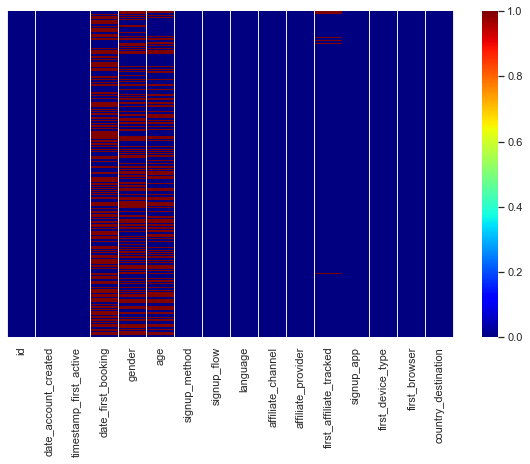

In [19]:
#Lets create a heatmap to see which all columns has null values
plt.figure(figsize=(10,6))
sns.heatmap(train_user.isnull(), yticklabels=False, cmap='jet',cbar='cyan')
plt.show;

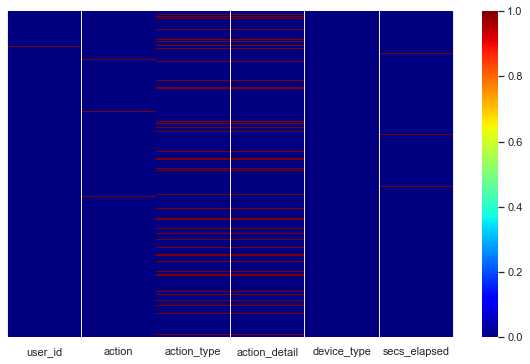

In [20]:
#Lets create a heatmap to see which all columns has null values
plt.figure(figsize=(10,6))
sns.heatmap(session.isnull(), yticklabels=False, cmap='jet',cbar='cyan')
plt.show;

In [21]:
#Columns with null values in the Train and test set

for df,nam in zip([train_user,test_user,session],['train_user','test_user','session']):
    var_with_na=[var for var in df.columns if df[var].isnull().sum()>=1 ]
    print(nam)
    for var in var_with_na:
        print(var, np.round(df[var].isnull().mean(),4)*10, '% missing values')
    print('\n')

train_user
date_first_booking 5.835 % missing values
gender 4.483 % missing values
age 4.122 % missing values
first_affiliate_tracked 0.28400000000000003 % missing values


test_user
date_first_booking 10.0 % missing values
gender 5.442 % missing values
age 4.65 % missing values
first_affiliate_tracked 0.0029999999999999996 % missing values


session
user_id 0.033 % missing values
action 0.075 % missing values
action_type 1.066 % missing values
action_detail 1.066 % missing values
secs_elapsed 0.129 % missing values




## Correlation

C:\Users\PK\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\PK\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


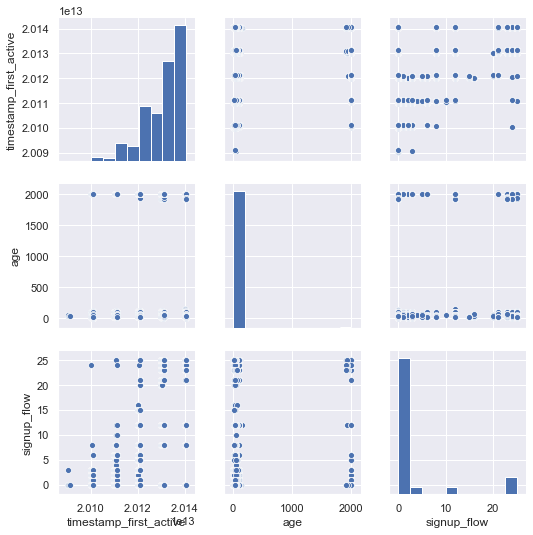

In [22]:
# see correlation
sns.pairplot(train_user);

## Destination

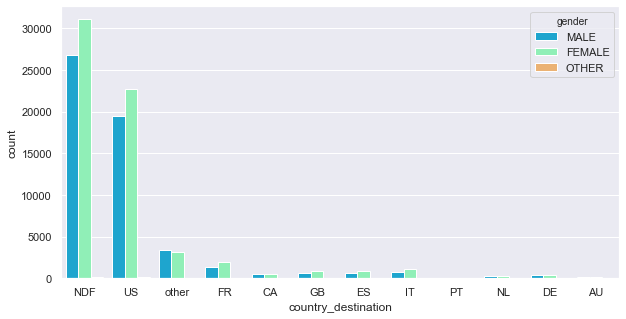

In [23]:
#let see our class split
fig  = plt.subplots(1,1,figsize=(10,5))
sns.countplot('country_destination',data=train_user,palette='rainbow',hue='gender');

It is overwhelm by NDF (country not in the list)

## Age

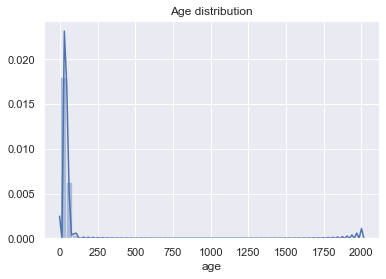

In [24]:
sns.distplot(train_user.age.dropna())
plt.title('Age distribution');

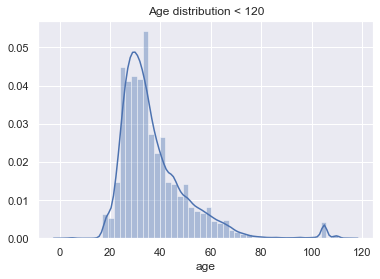

In [25]:
sns.distplot((train_user.age[train_user.age<120]).dropna())
plt.title('Age distribution < 120');

A little spike after `age` 100 is outliers

## Dates

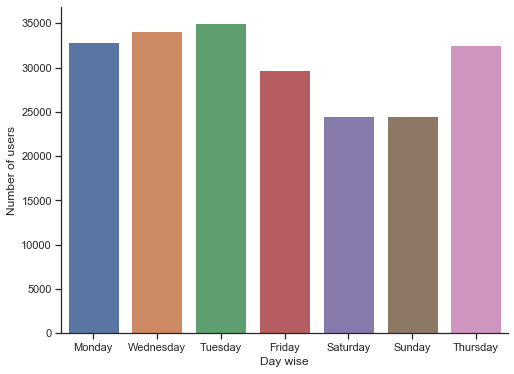

In [26]:
tmp3 = train_user.copy()
tmp3['date_account_created_new'] = pd.to_datetime(tmp3['date_account_created'])
tmp3['date_first_active_new'] = pd.to_datetime((tmp3.timestamp_first_active // 1000000), format='%Y%m%d')
tmp3['date_account_created_day'] = tmp3.date_account_created_new.dt.weekday_name
tmp3['date_account_created_month'] = tmp3.date_account_created_new.dt.month
tmp3['date_account_created_year'] = tmp3.date_account_created_new.dt.year
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
train_without_NDF = tmp3[tmp3['country_destination']!='US']
train_without_NDF1= train_without_NDF[train_without_NDF['country_destination']!='NDF']
sns.countplot(x='date_account_created_day',data=tmp3)
plt.xlabel('Day wise')
plt.ylabel('Number of users')
sns.despine()

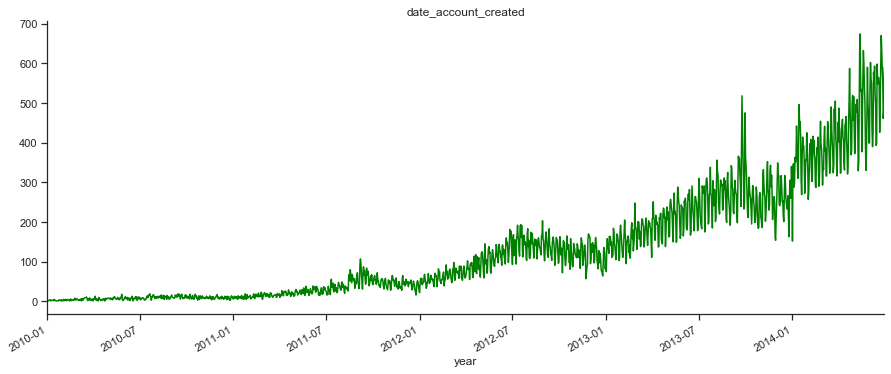

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
tmp3.date_account_created_new.value_counts().plot(kind='line', color='green')
plt.xlabel('year')
plt.title('date_account_created')
sns.despine()

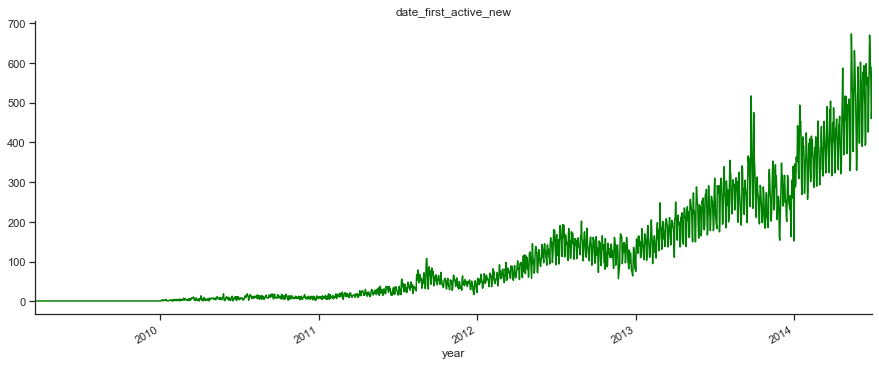

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
tmp3.date_first_active_new.value_counts().plot(kind='line', color='green')
plt.xlabel('year')
plt.title('date_first_active_new')
sns.despine()

## Sessions

In [29]:
session.describe(include=object)

,user_id,action,action_type,action_detail,device_type
count,10533241,10488111,9441533,9441533,10567737
unique,135483,359,10,155,14
top,mxqbh3ykxl,show,view,view_search_results,Mac Desktop
freq,2722,2768278,3560902,1776885,3594286


In [30]:
session.pivot_table('secs_elapsed',index='action').sort_values('secs_elapsed',ascending= False).round(1)

,secs_elapsed
action,
host_cancel,1224560.0
views_campaign,594896.0
recommend,441314.9
12,359056.6
maybe_information,307795.1
...,...
recommended_listings,462.9
apply_coupon_click_success,457.3
apply_coupon_error,361.6


# Data cleaning

First try without using `session`, `age_gender` and `country`
1. Drop unnecessary columns
    - id	
    - date_first_booking
2. Deal with
    - Age 
        - remove outliers (age over 80 and under 3)
        - Bin age range
        - fill with age bin that has highest population considering gender and country
    - Gender
        - convert unknown to np.nan
        - fill with gender that has highest population considering age and country
    - Convert date_time data

In [31]:
#split feature and target
Xtrain = train_user.drop('country_destination',axis=1)
ytrain = train_user['country_destination']

In [32]:
from sklearn.preprocessing import OneHotEncoder
def prepare_df(train,test):
    # combine data for enconding
    df = pd.concat([train,test],axis  = 0)
    ## get index for split
    splt_index = train.shape[0]
    #drop unecessary columns
    df.drop(['id','date_first_booking'],inplace=True,axis = 1)
    
    #date time 
    ## get the format
    df['date_account_created'] = pd.to_datetime(df['date_account_created'], errors='ignore')
    df['date_first_active'] = pd.to_datetime(df['timestamp_first_active'], format='%Y%m%d%H%M%S')
    ## to date_time
    date_account_created = pd.DatetimeIndex(df['date_account_created'])
    date_first_active = pd.DatetimeIndex(df['date_first_active'])
    ## split to day month weeks
    df['day_account_created'] = date_account_created.day
    df['weekday_account_created'] = date_account_created.weekday
    df['week_account_created'] = date_account_created.week
    df['month_account_created'] = date_account_created.month
    df['year_account_created'] = date_account_created.year
    df['day_first_active'] = date_first_active.day
    df['weekday_first_active'] = date_first_active.weekday
    df['week_first_active'] = date_first_active.week
    df['month_first_active'] = date_first_active.month
    df['year_first_active'] = date_first_active.year
    df.drop(['date_account_created', 'date_first_active', 'timestamp_first_active'],inplace=True,axis = 1)
    
    #age
    ## convert outliers to nan
    df['age'][df['age'] >100] = np.nan
    df['age'][df['age'] <8] = np.nan
    ## fill missing with -1
    df['age'].fillna(-1, inplace=True)
    ## bin them
    bins = [-1,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,np.inf]
    df['age_group'] = np.digitize(df['age'], bins, right=True)
    df.drop(['age'],inplace=True,axis = 1)
    #gender
    df['gender'].fillna(train_user['gender'].value_counts().index[0],inplace = True)
    #first affi
    df['first_affiliate_tracked'].fillna(train_user['first_affiliate_tracked'].value_counts().index[0], inplace = True)
    
    #Encoding (One-hot)
    categorical_features = [var for var in df.columns if df[var].dtypes == 'O']
    enc1 = OneHotEncoder(sparse=False)
    onehot = enc1.fit_transform(df[categorical_features])
    # drop
    df.drop(categorical_features,axis=1,inplace= True)
    #
    df = np.concatenate((df.values,onehot),axis = 1)
    #split train and test
    Xtrain_process = df[:splt_index]
    test_process   = df[splt_index:]
    print('Xtrain_process shape is ',Xtrain_process.shape ,' and test_process shape is ',test_process.shape)
    return Xtrain_process , test_process

In [33]:
Xtrain_process , test_process = prepare_df(Xtrain,test_user)

C:\Users\PK\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\PK\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Xtrain_process shape is  (213451, 146)  and test_process shape is  (62096, 146)


# Modeling

## Try different models

In [34]:
# split data for train and validation
from sklearn.model_selection import train_test_split
Xtrain_p, Xval,ytrain_p,yval = train_test_split(Xtrain_process,ytrain,test_size= 0.2)

In [37]:
#model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from  xgboost import XGBClassifier

svm_svc = SVC(kernel='linear')
rnd_c = RandomForestClassifier(n_estimators=200,max_depth=8)
ada_c = AdaBoostClassifier()
xgb_c = XGBClassifier()
sgd_c = SGDClassifier()
gra_c = GradientBoostingClassifier()

In [50]:
import sklearn.metrics as metrics
def classification_results(y_true, y_pred,estimator):
    # Classification metrics
    accuracy_score=metrics.accuracy_score(y_true, y_pred)
    f1_score=metrics.f1_score(y_true, y_pred,average='weighted') 
    balanced_accuracy_score=metrics.balanced_accuracy_score(y_true, y_pred) 

    return type(estimator).__name__,[round(accuracy_score,6),round(f1_score,6),round(balanced_accuracy_score,6)]

In [59]:
# fit and eval on training seta
ind, val = [],[]
for estimator in [rnd_c,ada_c,xgb_c,sgd_c,gra_c]:
    estimator.fit(Xtrain_p,ytrain_p)
    y_pred = estimator.predict(Xtrain_p)
    tmp1, tmp2  = classification_results(ytrain_p, y_pred,estimator)
    ind.append(tmp1)
    val.append(tmp2)
result1 = pd.DataFrame(np.array(val),index = [ind ],columns=['accuracy_score','f1_score','balanced_accuracy_score'])
result1.sort_values('accuracy_score',ascending=False)

,accuracy_score,f1_score,balanced_accuracy_score
GradientBoostingClassifier,0.635606,0.587511,0.117962
XGBClassifier,0.633749,0.584942,0.110105
AdaBoostClassifier,0.624684,0.571557,0.106493
RandomForestClassifier,0.598887,0.487740,0.090146
SGDClassifier,0.582707,0.429578,0.083454


In [76]:
# fit and eval on training seta
ind, val = [],[]
for estimator in [rnd_c,ada_c,xgb_c,sgd_c,gra_c]:
    y_pred = estimator.predict(Xval)
    tmp1, tmp2  = classification_results(yval, y_pred,estimator)
    ind.append(tmp1)
    val.append(tmp2)
result2 = pd.DataFrame(np.array(val),index = [ind ],columns=['accuracy_score','f1_score','balanced_accuracy_score'])
result2.sort_values('accuracy_score',ascending=False)

,accuracy_score,f1_score,balanced_accuracy_score
XGBClassifier,0.634630,0.585362,0.110482
GradientBoostingClassifier,0.634537,0.585428,0.110434
AdaBoostClassifier,0.625261,0.572107,0.106914
RandomForestClassifier,0.595793,0.474768,0.088289
SGDClassifier,0.583964,0.431126,0.083263
